[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/vq_gan/vq_gan_cnn.ipynb)

In [ ]:
from tqdm import tqdm
import numpy as np
from torchvision import utils as vutils
import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/khetansarvesh/CV.git

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=0) # loading the downloaded dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 899397.47it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134180.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274745.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5219322.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Modelling**

In [ ]:
from CV.data_augmentation.vq_vae.model import VQVAE

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
                                     nn.Conv2d(1, 128, kernel_size=2, stride=2, padding=1), nn.BatchNorm2d(128),nn.LeakyReLU(0.2, True),
                                     nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=1), nn.BatchNorm2d(256),nn.LeakyReLU(0.2, True),
                                     nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=1), nn.BatchNorm2d(512),nn.LeakyReLU(0.2, True),
                                     nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=1), nn.Identity(),nn.Sigmoid()
                                     )

    def forward(self, x):
        out = self.layer(x)
        return out

# **Training**

In [ ]:
generator = VQVAE().to(device)
opt_vq = torch.optim.Adam(generator.parameters() ,lr = 2.25e-05,eps = 1e-08,betas = (0.5, 0.9))

discriminator = Discriminator().to(device)
opt_disc = torch.optim.Adam(discriminator.parameters(),lr = 2.25e-05, eps = 1e-08, betas = (0.5, 0.9))

In [ ]:
for epoch in range(10):

    for imgs, _ in tqdm(mnist_loader):

        imgs = imgs.to(device)
        decoded_images, q_loss = generator(imgs)
        rec_loss = torch.abs(imgs - decoded_images).mean() # reconstruction loss

        disc_real = discriminator(imgs)
        disc_fake = discriminator(decoded_images)
        g_loss = -torch.mean(disc_fake) # gan loss

        disc_factor = 0. if epoch * 100 + 1 < 1000 else 1. # initially only discriminant is trained for 1000 epoch and generator is not trained so its loss should not be considered
        vq_loss = rec_loss + q_loss + disc_factor * g_loss # total loss = generator loss + discriminant loss = vqvae loss + gan loss = reconstruction loss + q_loss + gan loss

        d_loss_real = torch.mean(F.relu(1. - disc_real))
        d_loss_fake = torch.mean(F.relu(1. + disc_fake))
        gan_loss = disc_factor * 0.5*(d_loss_real + d_loss_fake)

        opt_vq.zero_grad()
        vq_loss.backward(retain_graph=True)

        opt_disc.zero_grad()
        gan_loss.backward()

        opt_vq.step()
        opt_disc.step()

        # testing
        # if i % 10 == 0:
        #     with torch.no_grad():
        #         real_fake_images = torch.cat((imgs[:4], decoded_images.add(1).mul(0.5)[:4]))


 28%|██▊       | 259/938 [03:54<09:35,  1.18it/s]

# **Inference**

In [ ]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (100, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
generated_im, _ = generator(test_ims.to(device))

In [ ]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

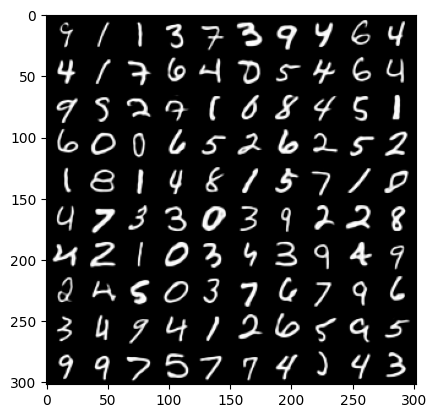

In [ ]:
# now printing the predicted images
import torchvision
grid = torchvision.utils.make_grid(generated_im, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')